In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

import os
from PIL import Image
import keras
import shutil
from pathlib import Path
from keras import layers
from keras import models
from keras import optimizers

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import LambdaCallback

2025-04-08 04:11:32.422922: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 04:11:32.504441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-08 04:11:32.504526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-08 04:11:32.509900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 04:11:32.530544: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 04:11:32.531244: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Investigating Data
Let's investigate our dataset and see what our images look like, and find some attributes of the image!

In [2]:
dmg_dir = "data/original_data/damage"
nodmg_dir = "data/original_data/no_damage"

dmg_img = os.listdir(dmg_dir)
nodmg_img = os.listdir(nodmg_dir)

all_img = [os.path.join(dmg_dir, f) for f in dmg_img[:5]] + \
          [os.path.join(nodmg_dir, f) for f in nodmg_img[:5]]

for img_path in all_img:
    with Image.open(img_path) as img:
        print(f"Image: {os.path.basename(img_path)}")
        print(f"  Format: {img.format}")
        print(f"  Size: {img.size} (width x height)")
        print(f"  Mode: {img.mode}")  # RGB, L (grayscale), etc.
        print()

Image: -96.96037700000001_28.783540999999996.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.138348_30.003827.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.632069_29.768672.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.268467_29.604840000000003.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.19982900000001_29.535064000000002.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -96.96037700000001_28.783540999999996.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.632069_29.768672.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.268467_29.604840000000003.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.19982900000001_29.535064000000002.jpeg
  Format: JPEG
  Size: (128, 128) (width x height)
  Mode: RGB

Image: -95.079831_30.031327.jpeg
  Format

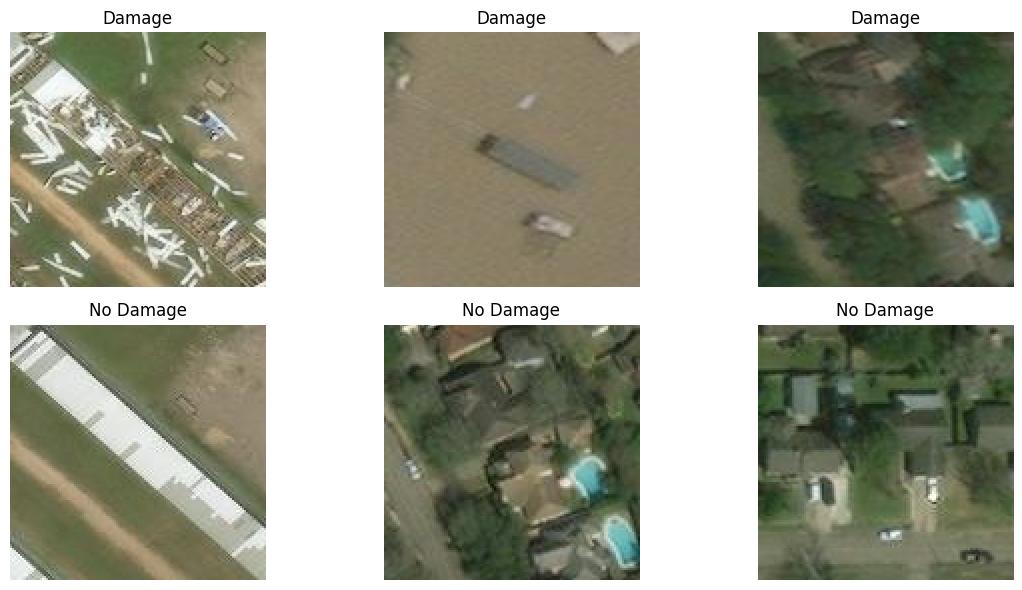

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, img_file in enumerate(dmg_img[:3]):
    img = Image.open(os.path.join(dmg_dir, img_file))
    axes[0, i].imshow(img)
    axes[0, i].set_title("Damage")
    axes[0, i].axis("off")

for i, img_file in enumerate(nodmg_img[:3]):
    img = Image.open(os.path.join(nodmg_dir, img_file))
    axes[1, i].imshow(img)
    axes[1, i].set_title("No Damage")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Based on our inspection, we can see that the size of the images are 128 by 128 pixels! This will be very useful for when we manipulate the data!

# Pre-Processing Data 
The first thing we need to do (before we start implementing any models) is clean our directories so we can ensure that when we train and test each directory, there won't be any discrepancies.

In [4]:
# cleaning our directories
try:
    shutil.rmtree("data/hurricane-split/train")
    shutil.rmtree("data/hurricane-split/test")
except:
    pass

In [5]:
# creating directories for each class in the train and test directories
Path("data/hurricane-split/train/damage").mkdir(parents=True, exist_ok=True)
Path("data/hurricane-split/train/no_damage").mkdir(parents=True, exist_ok=True)

Path("data/hurricane-split/test/damage").mkdir(parents=True, exist_ok=True)
Path("data/hurricane-split/test/no_damage").mkdir(parents=True, exist_ok=True)

In [6]:
# collect all the paths for images in each category so we can split them
all_dmg_path = os.listdir("data/original_data/damage")
all_nodmg_path = os.listdir("data/original_data/no_damage")

In [7]:
# split our data
trn_dmg = random.sample(all_dmg_path, int(len(all_dmg_path) * 0.8))
print("Training Damage image count:", len(trn_dmg))

tst_dmg = [p for p in all_dmg_path if p not in trn_dmg]
print("Testing Damage image count:", len(tst_dmg))

overlap = [p for p in trn_dmg if p in tst_dmg]
print("Length of overlap (damage):", len(overlap))


trn_nodmg = random.sample(all_nodmg_path, int(len(all_nodmg_path) * 0.8))
print("Training No Damage image count:", len(trn_nodmg))

tst_nodmg = [p for p in all_nodmg_path if p not in trn_nodmg]
print("Testing No Damage image count:", len(tst_nodmg))

overlap = [p for p in trn_nodmg if p in tst_nodmg]
print("Length of overlap (no_damage):", len(overlap))

Training Damage image count: 11336
Testing Damage image count: 2834
Length of overlap (damage): 0
Training No Damage image count: 5721
Testing No Damage image count: 1431
Length of overlap (no_damage): 0


In [8]:
# copy the files
for p in trn_dmg:
    shutil.copyfile(os.path.join('data/original_data/damage', p), os.path.join('data/hurricane-split/train/damage',p))
for p in tst_dmg:
    shutil.copyfile(os.path.join('data/original_data/damage', p), os.path.join('data/hurricane-split/test/damage',p))

for p in trn_nodmg:
    shutil.copyfile(os.path.join('data/original_data/no_damage', p), os.path.join('data/hurricane-split/train/no_damage',p))
for p in tst_nodmg:
    shutil.copyfile(os.path.join('data/original_data/no_damage', p), os.path.join('data/hurricane-split/test/no_damage',p))

print("Files in train/damage: ", len(os.listdir("data/hurricane-split/train/damage")))
print("Files in test/damage: ", len(os.listdir("data/hurricane-split/test/damage")))

print("Files in train/no_damage: ", len(os.listdir("data/hurricane-split/train/no_damage")))
print("Files in test/no_damage: ", len(os.listdir("data/hurricane-split/test/no_damage")))

Files in train/damage:  11336
Files in test/damage:  2834
Files in train/no_damage:  5721
Files in test/no_damage:  1431


In [9]:
train_data_dir = 'data/hurricane-split/train'

batch_size = 32
img_height = 128
img_width = 128

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# rescale instance
rescale = Rescaling(scale=1.0/255)

# apply the rescale to the train and validation sets
train_rescale_ds = train_ds.map(lambda image,label:(rescale(image),label))
val_rescale_ds = val_ds.map(lambda image,label:(rescale(image),label))

Found 17057 files belonging to 2 classes.
Using 13646 files for training.
Found 17057 files belonging to 2 classes.
Using 3411 files for validation.


In [10]:
test_data_dir = 'data/hurricane-split/test'

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=123,
    image_size=(img_height, img_width),
)

rescale = Rescaling(scale=1.0/255)
test_rescale_ds = test_ds.map(lambda image,label:(rescale(image),label))

Found 4265 files belonging to 2 classes.


# Model design, training, and evaluation
Now it is time to get to the fun stuff! We finally get to create ANN, Lenet-5 CNN, and Alternate-lenet-5 CNN architectures!

Let's get started! 

## Basic ANN

In [11]:
model_ann = models.Sequential()

# Flatten the input image to 1D
model_ann.add(layers.Flatten(input_shape=(128, 128, 3)))

# Fully connected layer with 128 neurons
model_ann.add(layers.Dense(128, activation='relu'))

# Fully connected layer with 64 neurons
model_ann.add(layers.Dense(64, activation='relu'))

# Output layer for 2 classes (damage, no_damage)
model_ann.add(layers.Dense(2, activation='softmax'))

# Now compile the model
model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Check model architecture
model_ann.summary()

model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 6299970 (24.03 MB)
Trainable params: 6299970 (24.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model_ann.fit(train_rescale_ds,batch_size=32,epochs=15,validation_data=val_rescale_ds)

Epoch 1/15
427/427 [==============================] - 12s 27ms/step - loss: 0.7967 - accuracy: 0.6504 - val_loss: 0.8246 - val_accuracy: 0.3465
Epoch 2/15
427/427 [==============================] - 12s 27ms/step - loss: 0.6540 - accuracy: 0.6797 - val_loss: 0.5441 - val_accuracy: 0.7520
Epoch 3/15
427/427 [==============================] - 12s 27ms/step - loss: 0.5888 - accuracy: 0.7082 - val_loss: 0.5391 - val_accuracy: 0.7590
Epoch 4/15
427/427 [==============================] - 12s 27ms/step - loss: 0.5680 - accuracy: 0.7152 - val_loss: 0.6316 - val_accuracy: 0.6681
Epoch 5/15
427/427 [==============================] - 11s 26ms/step - loss: 0.5976 - accuracy: 0.6638 - val_loss: 0.6648 - val_accuracy: 0.6681
Epoch 6/15
427/427 [==============================] - 11s 26ms/step - loss: 0.6129 - accuracy: 0.6637 - val_loss: 0.6373 - val_accuracy: 0.6681
Epoch 7/15
427/427 [==============================] - 11s 26ms/step - loss: 0.6379 - accuracy: 0.6637 - val_loss: 0.6358 - val_accuracy:

In [13]:
test_loss, test_accuracy = model_ann.evaluate(test_rescale_ds, verbose=0)
test_accuracy

0.6644783020019531

## Basic CNN

In [14]:
# Initialize sequential model
model_cnn = models.Sequential()

# First Conv layer
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(128, 128, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2), padding='same'))

# Second Conv layer
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(layers.MaxPooling2D((2, 2), padding='same'))

# Third Conv layer
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model_cnn.add(layers.MaxPooling2D((2, 2), padding='same'))

# Flatten to connect to dense layers
model_cnn.add(layers.Flatten())

# Fully connected layers
model_cnn.add(layers.Dense(100, activation='relu'))
model_cnn.add(layers.Dense(84, activation='relu'))

# Output layer: 2 neurons for binary classification
model_cnn.add(layers.Dense(2, activation='softmax'))

# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)       

In [15]:
history = model_cnn.fit(
    train_rescale_ds,
    batch_size=32,
    validation_data=val_rescale_ds,
    epochs=15
)

Epoch 1/15
427/427 [==============================] - 115s 267ms/step - loss: 0.4872 - accuracy: 0.7635 - val_loss: 0.3031 - val_accuracy: 0.8684
Epoch 2/15
427/427 [==============================] - 114s 268ms/step - loss: 0.2110 - accuracy: 0.9185 - val_loss: 0.1919 - val_accuracy: 0.9296
Epoch 3/15
427/427 [==============================] - 114s 267ms/step - loss: 0.1440 - accuracy: 0.9458 - val_loss: 0.1589 - val_accuracy: 0.9393
Epoch 4/15
427/427 [==============================] - 113s 266ms/step - loss: 0.1113 - accuracy: 0.9569 - val_loss: 0.1727 - val_accuracy: 0.9323
Epoch 5/15
427/427 [==============================] - 113s 263ms/step - loss: 0.0923 - accuracy: 0.9639 - val_loss: 0.1646 - val_accuracy: 0.9367
Epoch 6/15
427/427 [==============================] - 113s 265ms/step - loss: 0.0695 - accuracy: 0.9743 - val_loss: 0.1014 - val_accuracy: 0.9634
Epoch 7/15
427/427 [==============================] - 114s 267ms/step - loss: 0.0573 - accuracy: 0.9786 - val_loss: 0.1197 -

In [16]:
test_loss, test_accuracy = model_cnn.evaluate(test_rescale_ds, verbose=0)
test_accuracy

0.9563891887664795

## LeNet-5

In [22]:
# Define the model
model_lenet5 = models.Sequential()

# Update the input shape to match image size: 128x128x3
model_lenet5.add(layers.Conv2D(6, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

model_lenet5.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu'))
model_lenet5.add(layers.AveragePooling2D(pool_size=(2, 2)))

# flatten the 2D feature maps to 1D before passing to dense layers
model_lenet5.add(layers.Flatten())

# Fully connected layers
model_lenet5.add(layers.Dense(120, activation='relu'))
model_lenet5.add(layers.Dense(84, activation='relu'))

# Output layer: 2 neurons for binary classification (softmax for sparse_categorical_crossentropy)
model_lenet5.add(layers.Dense(2, activation='softmax'))

# Compile the model
model_lenet5.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Show model summary
model_lenet5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 6)       168       
                                                                 
 average_pooling2d_2 (Avera  (None, 63, 63, 6)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 16)        880       
                                                                 
 average_pooling2d_3 (Avera  (None, 30, 30, 16)        0         
 gePooling2D)                                                    
                                                                 
 flatten_4 (Flatten)         (None, 14400)             0         
                                                                 
 dense_11 (Dense)            (None, 120)              

In [23]:
# fit the model from image generator
history = model_lenet5.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds
)

Epoch 1/20
427/427 [==============================] - 21s 48ms/step - loss: 0.4563 - accuracy: 0.7979 - val_loss: 0.4015 - val_accuracy: 0.8168
Epoch 2/20
427/427 [==============================] - 21s 48ms/step - loss: 0.3113 - accuracy: 0.8832 - val_loss: 0.2674 - val_accuracy: 0.9018
Epoch 3/20
427/427 [==============================] - 20s 47ms/step - loss: 0.2125 - accuracy: 0.9228 - val_loss: 0.2173 - val_accuracy: 0.9162
Epoch 4/20
427/427 [==============================] - 20s 47ms/step - loss: 0.1667 - accuracy: 0.9360 - val_loss: 0.1994 - val_accuracy: 0.9244
Epoch 5/20
427/427 [==============================] - 20s 47ms/step - loss: 0.1314 - accuracy: 0.9523 - val_loss: 0.2328 - val_accuracy: 0.9223
Epoch 6/20
427/427 [==============================] - 20s 48ms/step - loss: 0.1090 - accuracy: 0.9604 - val_loss: 0.1687 - val_accuracy: 0.9399
Epoch 7/20
427/427 [==============================] - 20s 47ms/step - loss: 0.0824 - accuracy: 0.9708 - val_loss: 0.1787 - val_accuracy:

In [24]:
test_loss, test_accuracy = model_lenet5.evaluate(test_rescale_ds, verbose=0)
test_accuracy

0.9205158352851868

## Alternate LeNet-5

In [25]:
model_alt_lenet = models.Sequential()

# Conv Layer 1
model_alt_lenet.add(layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(128, 128, 3)))
model_alt_lenet.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2
model_alt_lenet.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model_alt_lenet.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
model_alt_lenet.add(layers.Conv2D(128, (5, 5), activation='relu', padding='same'))

# Flatten and Dense layers
model_alt_lenet.add(layers.Flatten())
model_alt_lenet.add(layers.Dense(64, activation='relu'))

# Output Layer for binary classification
model_alt_lenet.add(layers.Dense(2, activation='softmax'))

# Compile the model
model_alt_lenet.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model_alt_lenet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 128)       204928    
                                                                 
 flatten_5 (Flatten)         (None, 131072)           

In [26]:
# fit the model from image generator
history = model_alt_lenet.fit(
            train_rescale_ds,
            batch_size=32,
            epochs=20,
            validation_data=val_rescale_ds
)

Epoch 1/20
427/427 [==============================] - 186s 435ms/step - loss: 0.6480 - accuracy: 0.6603 - val_loss: 0.5630 - val_accuracy: 0.6904
Epoch 2/20
427/427 [==============================] - 180s 422ms/step - loss: 0.4132 - accuracy: 0.8178 - val_loss: 0.2595 - val_accuracy: 0.8924
Epoch 3/20
427/427 [==============================] - 185s 433ms/step - loss: 0.2818 - accuracy: 0.8889 - val_loss: 0.2527 - val_accuracy: 0.9030
Epoch 4/20
427/427 [==============================] - 182s 427ms/step - loss: 0.2265 - accuracy: 0.9135 - val_loss: 0.2254 - val_accuracy: 0.9188
Epoch 5/20
427/427 [==============================] - 184s 430ms/step - loss: 0.1904 - accuracy: 0.9266 - val_loss: 0.1781 - val_accuracy: 0.9317
Epoch 6/20
427/427 [==============================] - 184s 430ms/step - loss: 0.1562 - accuracy: 0.9419 - val_loss: 0.1969 - val_accuracy: 0.9247
Epoch 7/20
427/427 [==============================] - 182s 426ms/step - loss: 0.1224 - accuracy: 0.9516 - val_loss: 0.2012 -

In [27]:
test_loss, test_accuracy = model_alt_lenet.evaluate(test_rescale_ds, verbose=0)
test_accuracy

0.935052752494812